# Finetune Stardist with the Prov-GigaPath foundation model backbone

This example shows how to use `cellseg_models.pytorch` for finetuning [Stardist](https://arxiv.org/abs/1806.03535) for nuclei segmentation with the [Prov-GigaPath](https://huggingface.co/prov-gigapath/prov-gigapath) foundation backbone. We will be using hugginfaces [accelerate](https://huggingface.co/docs/accelerate/index) library to train the model.

**NOTE**: To run this notebook, you need to have been granted access to the UNI weights and agreed to the terms of the licence. You can request for access here: [Prov-GigaPath model pages](https://huggingface.co/prov-gigapath/prov-gigapath)

In [1]:
# !pip install cellseg-models-pytorch
# !pip install accelerate
# !pip install torchmetrics

In [2]:
from platform import python_version

import accelerate
import torch

import cellseg_models_pytorch

print("torch version:", torch.__version__)
print("accelerate version:", accelerate.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.1.1+cu121
accelerate version: 0.31.0
cellseg_models_pytorch version: 0.1.25
python version: 3.10.12


## Download Data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and the second fold as the training data and the third as the validation data.

Since we will train the [Stardist](https://github.com/stardist/stardist) model, we need to define the right nuclei instance transformations for training time. For Stardist, we define `"stardist"` and `"dist"` transformations. `"stardist"` transforms the labelled instance masks into radial distance maps and `"dist"` transforms the labelled instance masks into regular distance transformation maps. We also set `n_rays=32` to get 32 radial distance maps from the `"stardist"` transform.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"percentile"` normalization for the input images.

**NOTE** We need to add also the `resize` transformation here, since `Prov-GigaPath` was trained with a patch size of 224x224.

In [3]:
from pathlib import Path

from cellseg_models_pytorch.datamodules import PannukeDataModule

fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke_dataset"
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["dist", "stardist"],
    img_transforms=["blur", "hue_sat", "resize"],
    normalization="percentile",
    batch_size=8,
    num_workers=8,
    height=224,
    width=224,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data()  # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


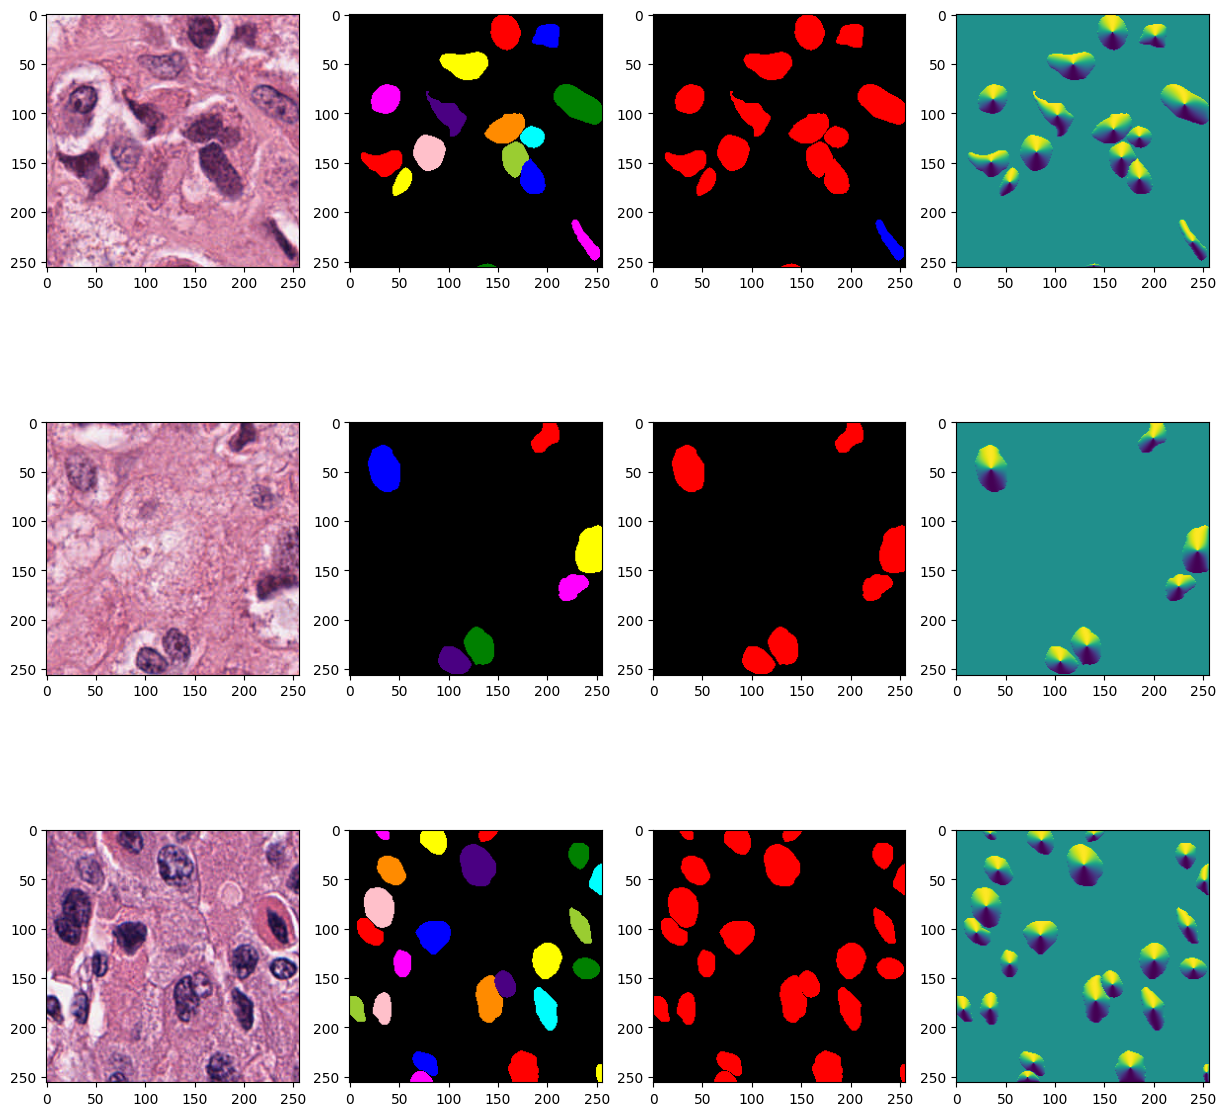

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb

from cellseg_models_pytorch.transforms.functional import gen_flow_maps

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_flow_maps(mask1["inst_map"])[0])
ax[4].imshow(im2)
ax[5].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[6].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[7].imshow(gen_flow_maps(mask2["inst_map"])[0])
ax[8].imshow(im3)
ax[9].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[10].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[11].imshow(gen_flow_maps(mask3["inst_map"])[0])

Next, we will define a simple `train`-loop wrapper function to train the model. The training logic in the wrapper is built with the [`accelerate`](https://huggingface.co/docs/accelerate/index). It is a convenient way to build training scripts in different types of computing environments. Check out https://huggingface.co/docs/accelerate/index for more.

**NOTE:**
In the training and validation loops we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "inst": torch.Tensor(B, H, W),
    "type": torch.Tensor(B, C, H, W)
    "stardist": torch.Tensor(B, 32, H, W)
    "dist": torch.Tensor(B, H, W)
}
```
We will access the `"image"` value in the training loop.
The rest of the masks will be handled automatically in the multi-task-loss function.

### **Training configuration**:

All of these are defined in the `train()`-wrapper function.

**The model**.
First, we will define the Stardist nuclei segmentation model with the foundation model `Prov-GigaPath` vision-encoder. Note that you need to have granted access to the weights in `hugginface_hub`. You must first use the `hugginface_hub` `login()`-function before you load the weights to the model (If you have been granted access and you've agreed to the terms of the licence).

**Branch losses.** For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"stardist"`- we set the masked `MAE`-loss like in the original paper. For the `"dist"`-outputs we use the masked `BCELoss` (binary-cross-entropy) with `MSE`, and for the `"type"`-output we will use the masked multiclass categorical `CELoss` with `DiceLoss`.

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the [CosineAnnealingLR](https://paperswithcode.com/paper/sgdr-stochastic-gradient-descent-with-warm) schedule. Initial lr is set to 0.0003. 

**Other hyperparams.**
We will train for 10 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

**NOTE** If torch >= 2.0 we can use the `torch.compile` to compile the model for better performance. Comment out if your pytorch version is less than 2.0 (Remember that the compiled models have bigger memory footprint than non-compiled.). Also, we will train with 16bit precision to lower memory-footprint.

In [5]:
import accelerate
from accelerate.utils import set_seed
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import JaccardIndex, MeanSquaredError
from tqdm import tqdm

from cellseg_models_pytorch.losses import (
    MAE,
    MSE,
    BCELoss,
    CELoss,
    DiceLoss,
    JointLoss,
    MultiTaskLoss,
)
from cellseg_models_pytorch.models import stardist_base_multiclass


# quick train wrapper func
def train():
    set_seed(42)

    # we will train with mixed precision
    project_dir = Path.home() / "pannuke" / "stardist_gigapath_accelerate"
    accelerator = accelerate.Accelerator(
        mixed_precision="fp16", project_dir=project_dir
    )

    # set dataloaders
    pannuke_module.setup()
    train_loader = pannuke_module.train_dataloader()
    val_loader = pannuke_module.val_dataloader()

    # Define the model with the function API.
    model = stardist_base_multiclass(
        enc_name="hf_hub:prov-gigapath/prov-gigapath",
        n_rays=32,  # number of predicted rays
        type_classes=len(pannuke_module.type_classes),
        enc_out_indices=(2, 4, 6, 8),
        out_size=(224, 224),
    )

    # Define the loss-functions for each decoder branch.
    # and wrap the losses in a MultiTaskLoss object. Since the Stardist model
    # outputs more than one output, it is considered a multi-task model.
    branch_losses = {
        "dist": JointLoss([BCELoss(apply_mask=True), MSE()]),
        "type": JointLoss([CELoss(), DiceLoss()]),
        "stardist": MAE(alpha=0.0001, apply_mask=True),
    }
    model.freeze_encoder()

    multitask_loss = MultiTaskLoss(
        branch_losses=branch_losses,
        loss_weights={
            "dist": 1.0,
            "type": 1.0,
            "stardist": 0.2,
        },
    )

    n_epochs = 10  # number of epochs to train for

    # optimizer and lr scheduler
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0003)
    lr_scheduler = CosineAnnealingLR(
        optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False
    )

    # training metrics
    type_cls_train_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)

    stardist_reg_train_metric = MeanSquaredError().to(accelerator.device)

    # validation metrics
    type_cls_val_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)

    stardist_reg_val_metric = MeanSquaredError().to(accelerator.device)

    # prepare the model, optimizer, and dataloaders for accelerate
    model, optimizer, train_loader, val_loader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_loader, val_loader, lr_scheduler
    )

    # metric values for plotting
    train_mious = []
    train_mses = []
    val_mious = []
    val_mses = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        with tqdm(train_loader, unit="batch") as loader:
            loader.set_description(f"Epoch: {epoch}")
            for batch in loader:
                # run forward pass and compute loss
                soft_masks = model(batch["image"])
                targets = {k: val for k, val in batch.items() if k != "image"}
                loss = multitask_loss(soft_masks, targets)

                # compute total loss for tracking
                total_loss += loss.detach().float()
                batch_miou = type_cls_train_metric(soft_masks["type"], targets["type"])
                batch_mse = stardist_reg_train_metric(
                    soft_masks["stardist"], targets["stardist"]
                )

                # round metrics to 4 decimal places for progress bar logging
                batch_miou = round(batch_miou.item(), 4)
                batch_mse = round(batch_mse.item(), 4)
                batch_loss = round(loss.item(), 4)

                # log loss and metrics in progress bar
                s = f"batch loss: {batch_loss}, batch miou: {batch_miou}, batch mse: {batch_mse}"
                loader.set_postfix_str(s)

                # run backward pass
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

        # metric on all batches using custom accumulation
        miou = type_cls_train_metric.compute()
        mse = stardist_reg_train_metric.compute()
        train_mious.append(miou)
        train_mses.append(mse)
        accelerator.print(
            f"total loss on all train data: {round(total_loss.item(), 4)}"
        )
        accelerator.print(f"type mIoU on all train data: {round(miou.item(), 4)}")
        accelerator.print(f"stardist mse on all train data: {round(mse.item(), 4)}")

        # Reseting internal state such that metrics are ready for new data
        type_cls_train_metric.reset()
        stardist_reg_train_metric.reset()

        # save model checkpoint
        accelerator.save_model(model, project_dir)

        # validation loop
        model.eval()
        with tqdm(val_loader, unit="batch") as loader:
            loader.set_description("Validation epoch")
            for batch in loader:
                with torch.no_grad():
                    soft_masks = model(batch["image"])
                    targets = {k: val for k, val in batch.items() if k != "image"}

                    loss = multitask_loss(soft_masks, targets)

                    # compute total loss for tracking
                    total_loss += loss.detach().float()
                    batch_miou = type_cls_val_metric(
                        soft_masks["type"], targets["type"]
                    )
                    batch_mse = stardist_reg_val_metric(
                        soft_masks["stardist"], targets["stardist"]
                    )

                    # round metrics to 4 decimal places for progress bar logging
                    batch_miou = round(batch_miou.item(), 4)
                    batch_mse = round(batch_mse.item(), 4)
                    batch_loss = round(loss.item(), 4)

                    # log loss and metrics in progress bar
                    s = f"val loss: {batch_loss}, val batch miou: {batch_miou}, val batch mse: {batch_mse}"
                    loader.set_postfix_str(s)

        # metric on all batches using custom accumulation
        miou = type_cls_val_metric.compute()
        mse = stardist_reg_val_metric.compute()
        val_mious.append(miou)
        val_mses.append(mse)
        accelerator.print(
            f"total val loss on all val data: {round(total_loss.item(), 4)}"
        )
        accelerator.print(f"val type mIoU on all val data: {round(miou.item(), 4)}")
        accelerator.print(f"val stardist mse on all val data: {round(mse.item(), 4)}")

        # Reseting internal state such that metrics are ready for new data
        type_cls_val_metric.reset()
        stardist_reg_val_metric.reset()

    fig, ax = type_cls_val_metric.plot(val_mious)
    plt.show()

Launching training on one GPU.
(256, 128, 64, 32) [{'module': 'blocks.2', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.4', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.6', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.8', 'num_chs': 1536, 'reduction': 16}]


Epoch: 0: 100%|██████████| 648/648 [03:31<00:00,  3.07batch/s, batch loss: 1.7039, batch miou: 0.4684, batch mse: 29.0655]


total loss on all train data: 1156.5291
type mIoU on all train data: 0.1867
stardist mse on all train data: 30.5225


Validation epoch: 100%|██████████| 341/341 [02:39<00:00,  2.14batch/s, val loss: 1.8276, val batch miou: 0.2524, val batch mse: 22.5926]


total val loss on all val data: 1719.4474
val type mIoU on all val data: 0.2449
val stardist mse on all val data: 24.2081


Epoch: 1: 100%|██████████| 648/648 [07:09<00:00,  1.51batch/s, batch loss: 1.3538, batch miou: 0.356, batch mse: 16.6475] 


total loss on all train data: 1015.6377
type mIoU on all train data: 0.2413
stardist mse on all train data: 21.6477


Validation epoch: 100%|██████████| 341/341 [03:53<00:00,  1.46batch/s, val loss: 1.5972, val batch miou: 0.3518, val batch mse: 19.1201]


total val loss on all val data: 1552.261
val type mIoU on all val data: 0.2368
val stardist mse on all val data: 21.2224


Epoch: 2: 100%|██████████| 648/648 [09:57<00:00,  1.08batch/s, batch loss: 1.2914, batch miou: 0.2886, batch mse: 11.4169]


total loss on all train data: 1022.0117
type mIoU on all train data: 0.2436
stardist mse on all train data: 21.2055


Validation epoch: 100%|██████████| 341/341 [04:38<00:00,  1.22batch/s, val loss: 1.7535, val batch miou: 0.1972, val batch mse: 17.2634]


total val loss on all val data: 1551.2406
val type mIoU on all val data: 0.2409
val stardist mse on all val data: 18.9851


Epoch: 3: 100%|██████████| 648/648 [10:35<00:00,  1.02batch/s, batch loss: 1.5554, batch miou: 0.298, batch mse: 18.6109] 


total loss on all train data: 987.216
type mIoU on all train data: 0.2823
stardist mse on all train data: 19.8654


Validation epoch: 100%|██████████| 341/341 [04:39<00:00,  1.22batch/s, val loss: 1.6648, val batch miou: 0.2847, val batch mse: 18.3039]


total val loss on all val data: 1490.0714
val type mIoU on all val data: 0.3115
val stardist mse on all val data: 18.8251


Epoch: 4: 100%|██████████| 648/648 [09:58<00:00,  1.08batch/s, batch loss: 1.1035, batch miou: 0.2963, batch mse: 2.6078] 


total loss on all train data: 936.9181
type mIoU on all train data: 0.3317
stardist mse on all train data: 18.3507


Validation epoch: 100%|██████████| 341/341 [04:12<00:00,  1.35batch/s, val loss: 1.5753, val batch miou: 0.2519, val batch mse: 18.0344]


total val loss on all val data: 1433.9642
val type mIoU on all val data: 0.3291
val stardist mse on all val data: 18.3605


Epoch: 5: 100%|██████████| 648/648 [08:08<00:00,  1.33batch/s, batch loss: 1.43, batch miou: 0.254, batch mse: 7.3377]    


total loss on all train data: 953.379
type mIoU on all train data: 0.3171
stardist mse on all train data: 18.6121


Validation epoch: 100%|██████████| 341/341 [04:27<00:00,  1.28batch/s, val loss: 1.5161, val batch miou: 0.2739, val batch mse: 18.4021]


total val loss on all val data: 1458.9673
val type mIoU on all val data: 0.3047
val stardist mse on all val data: 18.2422


Epoch: 6: 100%|██████████| 648/648 [10:03<00:00,  1.07batch/s, batch loss: 1.3443, batch miou: 0.4536, batch mse: 9.3008] 


total loss on all train data: 940.8226
type mIoU on all train data: 0.3238
stardist mse on all train data: 17.2371


Validation epoch: 100%|██████████| 341/341 [04:15<00:00,  1.33batch/s, val loss: 1.5104, val batch miou: 0.271, val batch mse: 15.3234] 


total val loss on all val data: 1424.3226
val type mIoU on all val data: 0.3646
val stardist mse on all val data: 14.9716


Epoch: 7: 100%|██████████| 648/648 [09:12<00:00,  1.17batch/s, batch loss: 1.579, batch miou: 0.4409, batch mse: 39.7438] 


total loss on all train data: 893.2222
type mIoU on all train data: 0.3645
stardist mse on all train data: 14.9058


Validation epoch: 100%|██████████| 341/341 [03:15<00:00,  1.74batch/s, val loss: 1.4528, val batch miou: 0.2849, val batch mse: 14.7104]


total val loss on all val data: 1365.8944
val type mIoU on all val data: 0.3676
val stardist mse on all val data: 14.5601


Epoch: 8: 100%|██████████| 648/648 [06:48<00:00,  1.59batch/s, batch loss: 1.4388, batch miou: 0.3399, batch mse: 19.6247]


total loss on all train data: 905.6626
type mIoU on all train data: 0.3512
stardist mse on all train data: 14.9681


Validation epoch: 100%|██████████| 341/341 [03:16<00:00,  1.74batch/s, val loss: 1.5302, val batch miou: 0.2699, val batch mse: 16.7492]


total val loss on all val data: 1395.5814
val type mIoU on all val data: 0.3441
val stardist mse on all val data: 15.9359


Epoch: 9: 100%|██████████| 648/648 [09:00<00:00,  1.20batch/s, batch loss: 1.3157, batch miou: 0.3273, batch mse: 6.2454] 


total loss on all train data: 905.2932
type mIoU on all train data: 0.3486
stardist mse on all train data: 14.6041


Validation epoch: 100%|██████████| 341/341 [04:18<00:00,  1.32batch/s, val loss: 1.4061, val batch miou: 0.2895, val batch mse: 14.3428]


total val loss on all val data: 1373.3778
val type mIoU on all val data: 0.3789
val stardist mse on all val data: 13.827


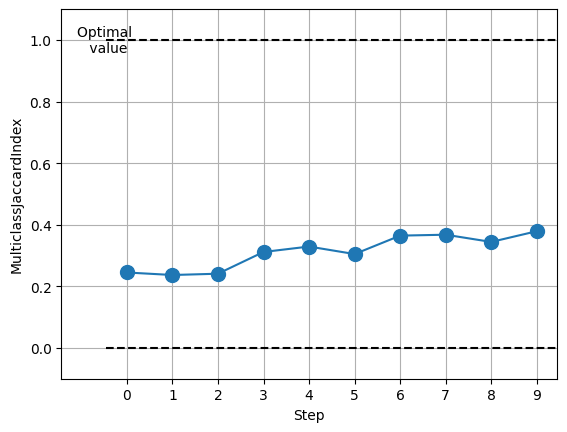

In [6]:
from accelerate import notebook_launcher

notebook_launcher(train, num_processes=1, mixed_precision="fp16")

# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 10 epochs of training. 

Especially, we will look at the `stardist`, `type` and the `dist` maps.

- The `dist` maps are used as the object (nuclei) probability that determine whether the model detects objects as nuclei or not.
- The `stardist` maps on the other hand are used as the input for the NMS-based `stardist`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

In [7]:
from accelerate import load_checkpoint_and_dispatch

# The model state dict was saved in the project_dir
model = stardist_base_multiclass(
    enc_name="hf_hub:prov-gigapath/prov-gigapath",
    n_rays=32,  # number of predicted rays
    type_classes=len(pannuke_module.type_classes),
    enc_out_indices=(2, 4, 6, 8),
)

model = load_checkpoint_and_dispatch(
    model,
    checkpoint=(
        Path.home() / "pannuke/stardist_gigapath_accelerate/model.safetensors"
    ).as_posix(),
)

(256, 128, 64, 32) [{'module': 'blocks.2', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.4', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.6', 'num_chs': 1536, 'reduction': 16}, {'module': 'blocks.8', 'num_chs': 1536, 'reduction': 16}]


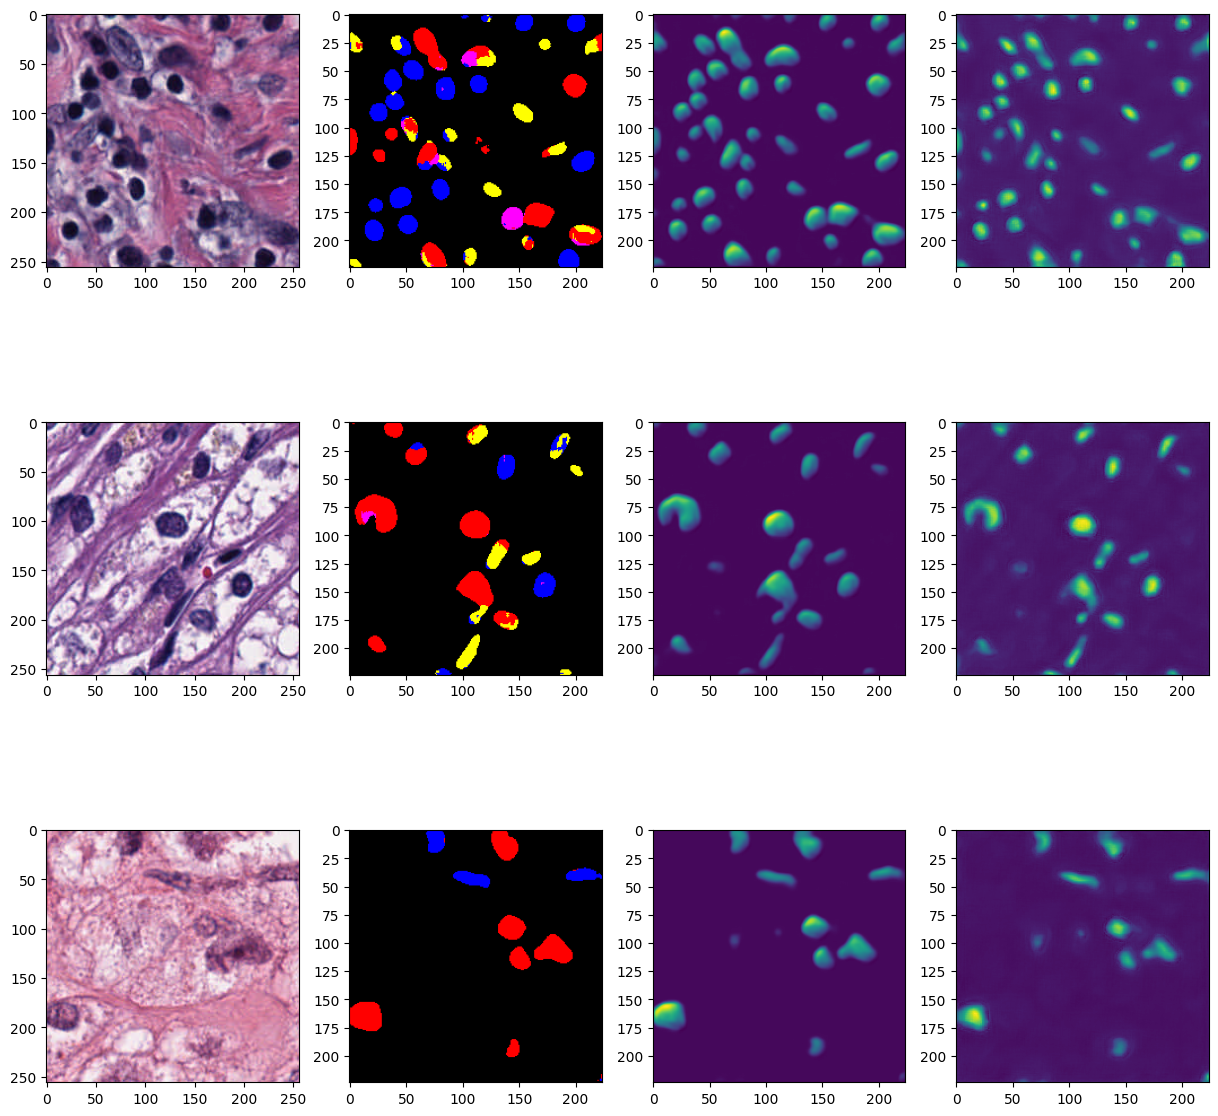

In [9]:
import torch.nn.functional as F

from cellseg_models_pytorch.utils import percentile_normalize

img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])

img1 = F.interpolate(
    torch.from_numpy(percentile_normalize(im1)).permute(2, 0, 1).unsqueeze(0).float(),
    size=224,
)
img2 = F.interpolate(
    torch.from_numpy(percentile_normalize(im2)).permute(2, 0, 1).unsqueeze(0).float(),
    size=224,
)
img3 = F.interpolate(
    torch.from_numpy(percentile_normalize(im3)).permute(2, 0, 1).unsqueeze(0).float(),
    size=224,
)

pred1 = model(img1)
pred2 = model(img2)
pred3 = model(img3)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(
    label2rgb(
        np.argmax(pred1["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[2].imshow(pred1["stardist"].squeeze().detach().cpu().numpy()[5])
ax[3].imshow(pred1["dist"].squeeze().detach().cpu().numpy())
ax[4].imshow(im2)
ax[5].imshow(
    label2rgb(
        np.argmax(pred2["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[6].imshow(pred2["stardist"].squeeze().detach().cpu().numpy()[5])
ax[7].imshow(pred2["dist"].squeeze().detach().cpu().numpy())
ax[8].imshow(im3)
ax[9].imshow(
    label2rgb(
        np.argmax(pred3["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[10].imshow(pred3["stardist"].squeeze().detach().cpu().numpy()[5])
ax[11].imshow(pred3["dist"].squeeze().detach().cpu().numpy())

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `cellseg_models_pytorch.inference` module. 

Since the Pannuke-dataset has only 256x256px images, we will use the `ResizeInferer` to run the inference and post-processing, resizing the images to 224x224. The `Inferer`s take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, naturally, we will use `stardist` post-processing since we're running inference for a Stardist model.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the predictions. This can only be useful when inference is run for bigger images that are patched in overlapping patches (inference with overlapping patches can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 50 first images of inside the input folder.

**NOTE**: Another important thing to note here, is that the `"stardist"` post-proc method is not the original one introduced in the [Stardist](https://github.com/stardist/stardist) paper. It is a python rewrite of the original one and can be even twice as fast as the orig one with only neglible differneces in the output. However, if you like, you can use the original by setting `instance_postproc` to `"stardist_orig"`. It should be noted that the original version requires also the original `stardist` library that can be installed with `pip install stardist`.

In [11]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=model,
    input_path=save_dir / "valid" / "images",
    out_activations={"dist": None, "stardist": None, "type": "softmax"},
    out_boundary_weights={"dist": False, "stardist": False, "type": False},
    resize=(224, 224),  # Not actually resizing anything,
    instance_postproc="stardist",
    batch_size=8,
    n_images=50,  # Use only the 50 first images of the folder
    normalization="percentile",
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:04<00:00,  1.54batch/s, post-processing]


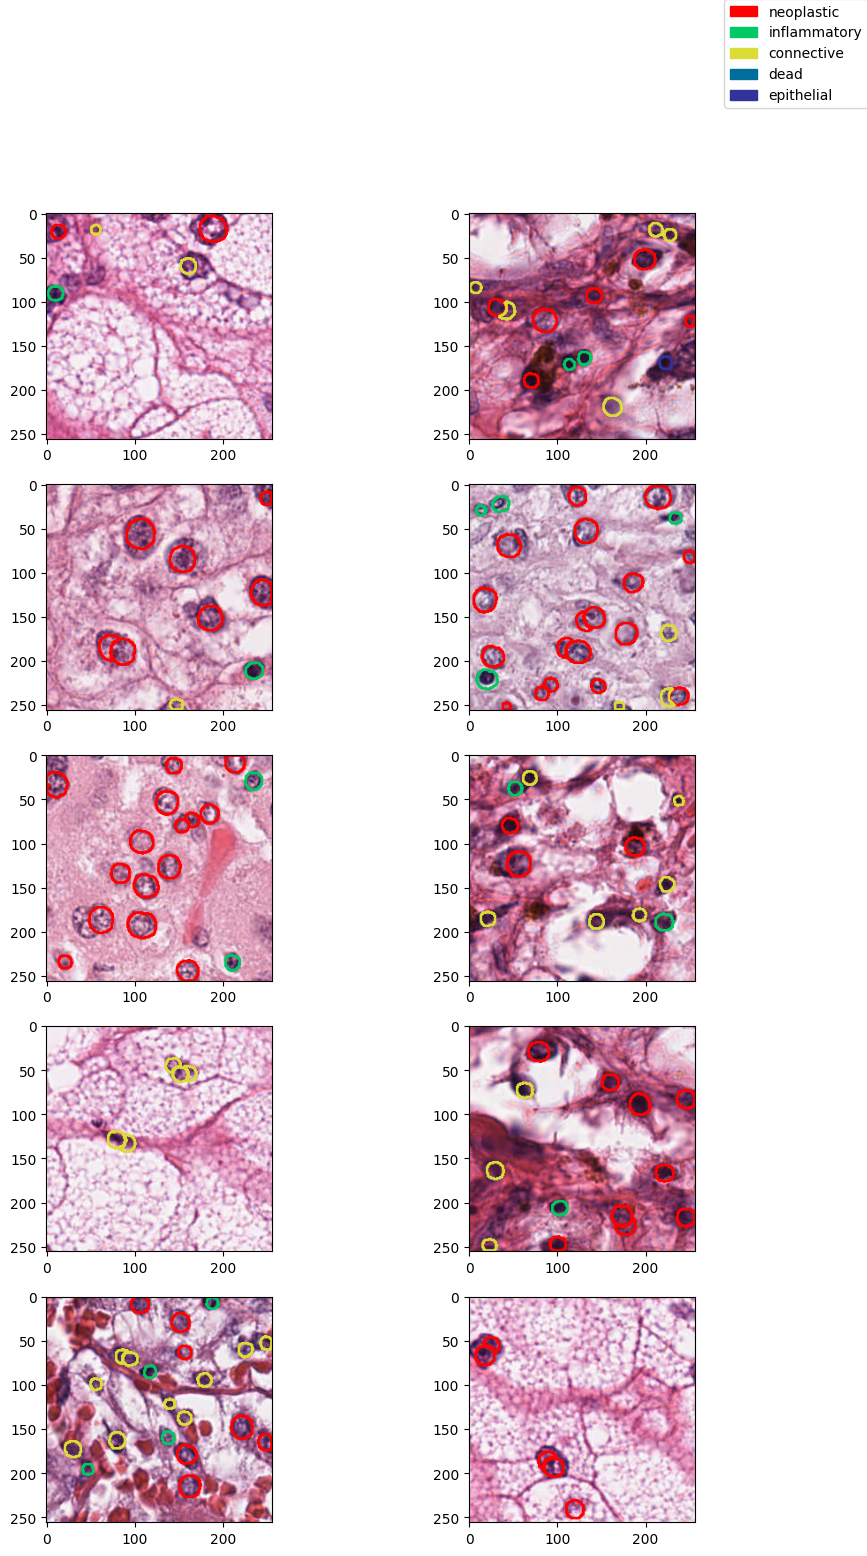

In [14]:
import matplotlib.patches as mpatches
import numpy as np

from cellseg_models_pytorch.utils import draw_thing_contours

fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)

# add legend
cmap = {
    1: (255.0 / 255, 0.0, 0.0),
    2: (0.0, 200.0 / 255, 100.0 / 255),
    3: (220.0 / 255, 220.0 / 255, 55.0 / 255),
    4: (0.0, 110.0 / 255, 155.0 / 255),
    5: (50.0 / 255, 50.0 / 255, 155.0 / 255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig.legend(handles=patches, loc=1, borderaxespad=0)